In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold
import fasttext
import pickle

import sys
sys.path.append('/project/dissertation')

# Load custom modules
from utils.config import config as cf
import utils.feature_eng_utils as feature_utils
from utils import ml_models
from utils import text_embedding
from utils.text_embedding import MeanEmbeddingVectorizer, FastTextVectorizer

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


# Load Training data

In [2]:
df = pd.read_csv(cf.DATA_PATH+'/train.csv')
df['Description'] = df['Description'].fillna('')

df = feature_utils.preprocess_description(df, True)
X = df['Description']
y = df['label']
df.isna().sum()

======= Load Currency :::  /project/dissertation/resources/currency.csv
Total  285  rows
======= Load Cities name :::  /project/dissertation/resources/nz_cities.csv
Total  1040  rows
======= Load Stopword name :::  /project/dissertation/resources/stop_words.csv
Total  10  rows


Date                 0
Description          0
Amount               0
Category             0
Business/Personal    0
Bank                 0
Account Type         0
isOverseas           0
isExpense            0
Amount_logabs        0
Type                 0
Main Category        0
label                0
desc                 0
isAcctNo             0
isForeignCurr        0
dtype: int64

In [3]:
base_models = {
    'SVC': SVC(C=100, kernel= 'rbf', gamma='scale',class_weight='balanced', random_state=cf.RANDOM_ST),
}
vectorizers = {
    'Bag-Of-Words' : CountVectorizer(analyzer=lambda x: x, max_features=None),
    'TF-iDF' : TfidfVectorizer(analyzer=lambda x: x, max_features=None),
}

all_models = {
    'Bag-Of-Words' : make_pipeline(vectorizers['Bag-Of-Words'], base_models['SVC']),
    'TF-iDF' : make_pipeline(vectorizers['TF-iDF'], base_models['SVC']),
}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=cf.RANDOM_ST)


---------------------------------------------------------
# 1. Analyse Count-based Methods

## 1.1 Analyse n-gram

In [5]:
X_sent = [' '.join(x) for x in df['Description']]
ngram_result = list()
for n in range(1,5):
    tfidf_vec =  TfidfVectorizer(ngram_range=(1,n))
    count_vec =  CountVectorizer(ngram_range=(1,n))
    x_transformed = tfidf_vec.fit_transform(X_sent)
    countVec_transformed = count_vec.fit_transform(X_sent)
    
    score_tfidf = cross_val_score( base_models['SVC'], x_transformed, y, cv=kfold, scoring='f1_macro').mean()
    score_count = cross_val_score( base_models['SVC'], countVec_transformed, y, cv=kfold, scoring='f1_macro').mean()
    print('n :{}, score: {}'.format(n,score_tfidf))
    ngram_result.append({'n': n, 'score': score_tfidf, 'type': 'TF-iDF'})
    ngram_result.append({'n': n, 'score': score_count, 'type': 'Bag-of-Words'})

n :1, score: 0.8028154644686237
n :2, score: 0.7924244249948129
n :3, score: 0.7868346062392801
n :4, score: 0.7868986447848367


In [6]:
ngram_df = pd.DataFrame(ngram_result)
ngram_df.to_csv(cf.EXPORT_PATH + 'count_vec_ngram.csv', index=False)

[Text(0, 0.5, 'F1-Score')]

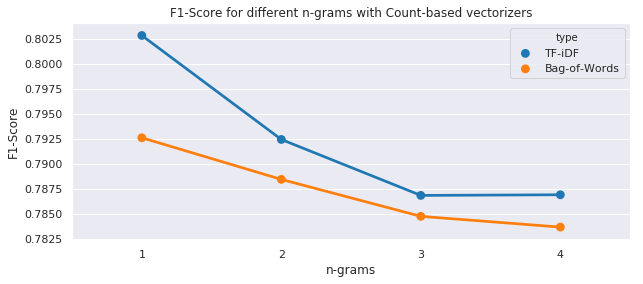

In [14]:
ngram_df = pd.read_csv(cf.EXPORT_PATH + 'count_vec_ngram.csv')
plt.figure(figsize=(10,4))
fig= sns.pointplot(x='n', y='score', hue='type', data=ngram_df)
sns.set_context('notebook', font_scale=1)
sns.set_style('darkgrid')
fig.set(xlabel='n-grams')
fig.set(title='F1-Score for different n-grams with Count-based vectorizers')
fig.set(ylabel="F1-Score")

## 1.2 Analyse maximum number of features

In [15]:
vec_result = list()
for n in range(100, 3200, 100):
    print(n, end=' ')
    countVec = CountVectorizer(analyzer = lambda x:x,  max_features=n)
    pipeline_countVec = make_pipeline(countVec,  base_models['SVC'])
    score_countVec = cross_val_score(pipeline_countVec, X, y, cv=kfold, scoring='f1_macro', n_jobs=-1).mean()
    
    tfidfVec = TfidfVectorizer(analyzer = lambda x:x,  max_features=n)
    pipeline_tfidfVec = make_pipeline(tfidfVec,  base_models['SVC'])
    score_tfidfVec = cross_val_score(pipeline_tfidfVec, X, y, cv=kfold, scoring='f1_macro', n_jobs=-1).mean()
    
    vec_result.append({'max_features': n,  'Bag-of-Word': score_countVec, 'TF-iDF': score_tfidfVec})
print('Done!')

100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 Done!


In [16]:
vec_result_df = pd.DataFrame(vec_result)
vec_result_df.to_csv(cf.EXPORT_PATH + 'count_vec_max_features.csv')

[Text(0, 0.5, 'F1-Score')]

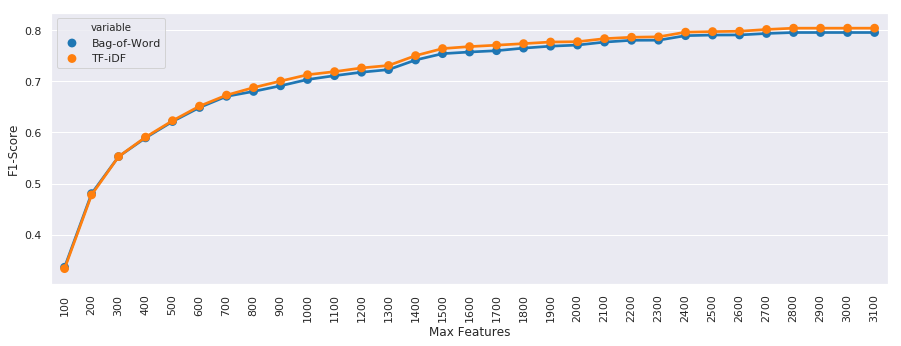

In [17]:
vec_result_df = pd.read_csv(cf.EXPORT_PATH + 'count_vec_max_features.csv')
vec_df_melted= vec_result_df.melt(id_vars='max_features', value_vars=['Bag-of-Word', 'TF-iDF'])
plt.figure(figsize=(15,5))
fig = sns.pointplot(x='max_features', y='value', hue='variable', legend='full', data=vec_df_melted)
loc, labels = plt.xticks()
fig.set_xticklabels(labels, rotation=90)
sns.set_context('notebook', font_scale=1)
sns.set_style('darkgrid')
fig.set(xlabel='Max Features')
fig.set(ylabel='F1-Score')

---------------------------------------------------------------------------
# 2. Analyse Text-Embedding methods

## 2.1 W2V model

<div class='alert alert-warning'>
    <b>Load pre-trained model</b> <code>GoogleNews-vectors-negative300.bin</code>
    <p>This pre-trained model file size is larger than 3GB. Please make sure to have enough RAM for this file. </p>
    <p>The file is available to download <a href ="https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing">here</a> (From : https://code.google.com/archive/p/word2vec/)</p>
    </div>


In [4]:
import gensim 
w2v_bin_file = cf.PRETRAINED_W2V_BIN
w2v_model = gensim.models.KeyedVectors.load_word2vec_format(w2v_bin_file, binary=True) 

### - Analyse OOV words

In [5]:
def w2v_oov_condition(w2v_model, token):
    return (token in w2v_model.vocab) or (token.capitalize() in w2v_model.vocab) or (token.upper() in w2v_model.vocab)
    
distinct_oov, total_oov, oob_words = text_embedding.analyse_oov(X, w2v_model, w2v_oov_condition)

Distinct OOV words : 19.52%
Words represented by a vector of zeros : 7.47%


In [6]:
vectorizers['W2V']  = text_embedding.W2VVectorizer(w2v_model)
X2 = vectorizers['W2V'].transform(np.array(X))

### -  CV score

In [18]:
scoring = {'accuracy': 'accuracy',  'precision': 'precision_macro', 'recall': 'recall_macro', 'f1': 'f1_macro'}
w2v_score = cross_validate(base_models['SVC'], X2, y, cv=kfold, scoring=scoring)
ml_models.export_results('W2V', w2v_score)

Export done! :  /project/dissertation/output/embedding_results/W2V.csv


In [19]:
pd.DataFrame(w2v_score).mean()

fit_time          31.132518
score_time        16.424448
test_accuracy      0.859864
test_precision     0.814777
test_recall        0.761021
test_f1            0.760815
dtype: float64

### - Benchmarks

In [9]:
selected_models = {'W2V': base_models['SVC']}
all_results = ml_models.benchmark_models(selected_models, X2, y, export_results=True, n_jobs=1)

W2V : 100 ...200 ...400 ...800 ...1600 ...3200 ...6400 ...10000 ...done !
Export done! : /project/dissertation/output/embedding_benchmark_results/W2V.csv


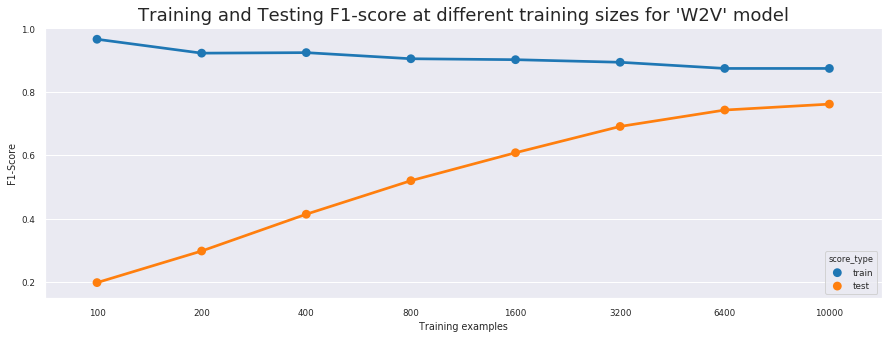

In [12]:
ml_models.plot_benchmark_train_test_score(all_results, 'W2V')

### - Classification Report & Confusion Matrix

Train : 10336  Test : 2584  Total : 12920
                                                             precision    recall  f1-score   support

                Expenses::Business Phone::Mobile Phone Bill       1.00      0.94      0.97        33
                           Expenses::Business Vehicle::Fuel       0.89      0.78      0.83        90
            Expenses::Business Vehicle::Maintenance & Tyres       1.00      0.64      0.78        11
                Expenses::Business Vehicle::Parking & Tolls       0.93      0.92      0.93        61
             Expenses::Business Vehicle::Registration & Wof       1.00      0.33      0.50         3
     Expenses::Charities & Donations::Charities & Donations       1.00      0.50      0.67         4
                   Expenses::Commercial Office::Office Rent       1.00      0.50      0.67         2
          Expenses::General Business::Advertising/Marketing       0.75      0.75      0.75         4
                      Expenses::General Business

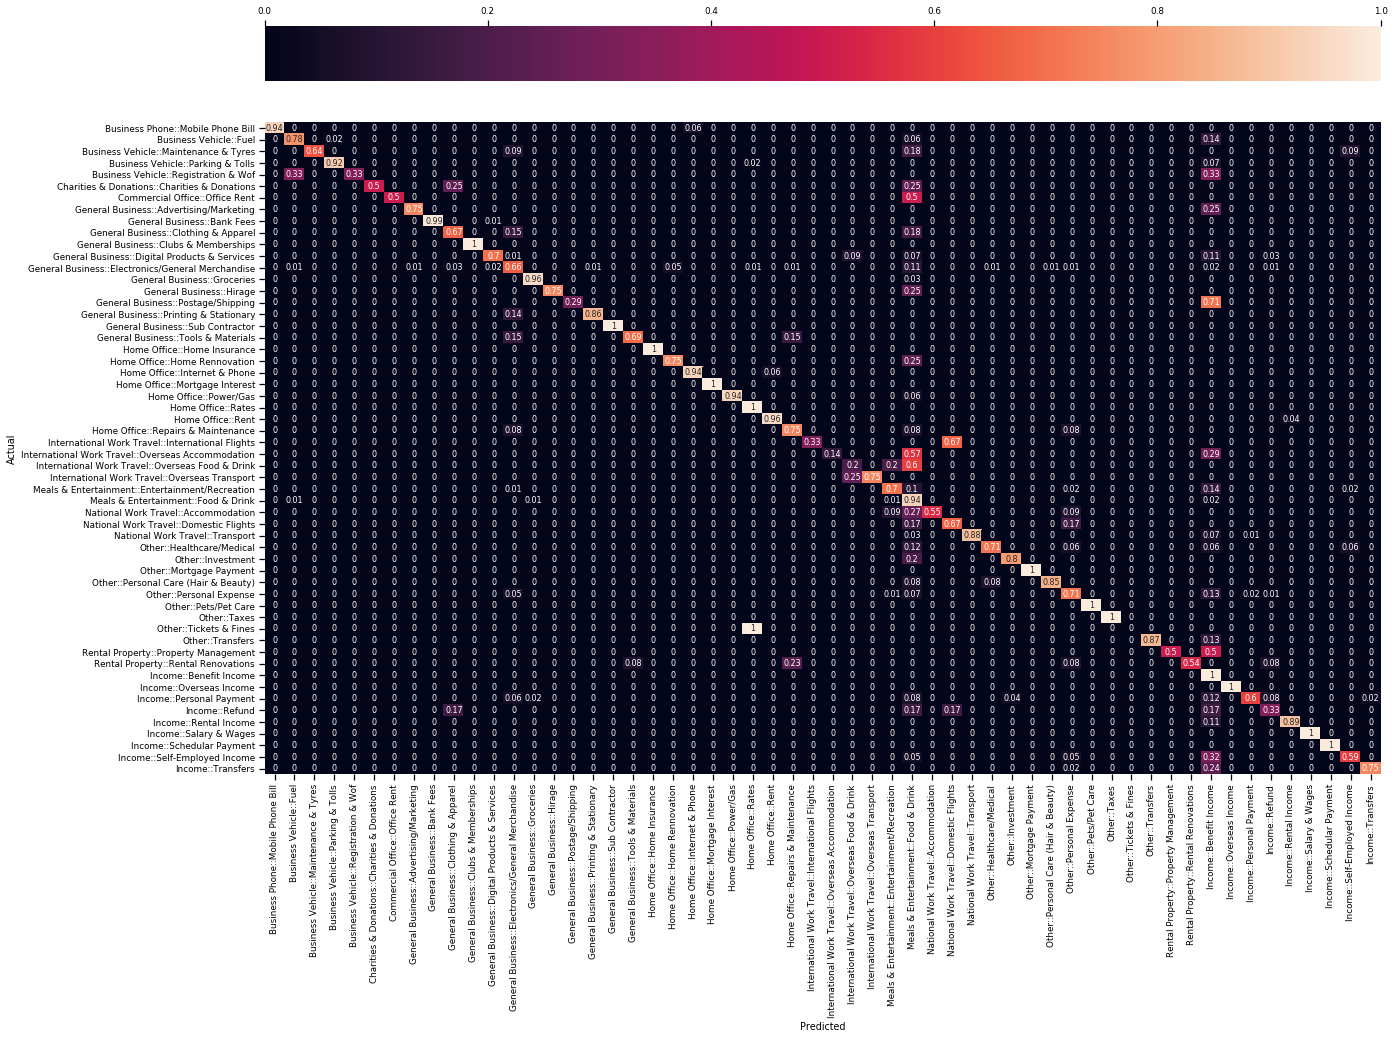

In [7]:
w2v_result = ml_models.evaluate_pipeline(base_models['SVC'], X2, y)

## 2.2 FastText Model

<div class='alert alert-warning'>
    <b>Load pre-trained model</b>  <code>wiki-news-300d-1M-subword.bin</code>
    <p>This pre-trained model file size is larger than 6.8 GB. Please make sure to have enough RAM for this file. </p>
    <p>The file is available to download <a href ="https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M-subword.bin.zip">here</a> (From : https://fasttext.cc/docs/en/english-vectors.html)</p>
    </div>

In [2]:
fasttext_model = fasttext.FastText.load_model(cf.PRETRAINED_FASTTEXT_BIN) 

In [7]:
vectorizers['FastText'] = FastTextVectorizer(fasttext_model)
X2 = vectorizers['FastText'].transform(X)

### - Analyse OOV words

In [7]:
def fasttext_oov_condition(fasttext, token):
    return fasttext.get_word_id(token) != -1

distinct_oov, total_oov, oob_words = text_embedding.analyse_oov(X, fasttext_model, fasttext_oov_condition)

Distinct OOV words : 27.80%
Words represented by a vector of zeros : 11.87%


### - CV Score

In [8]:
scoring = {'accuracy': 'accuracy',  'precision': 'precision_macro', 'recall': 'recall_macro', 'f1': 'f1_macro'}
fasttext_score = cross_validate(base_models['SVC'], X2, y, cv=kfold, scoring=scoring)
ml_models.export_results('FastText', fasttext_score)

Export done! :  /project/dissertation/output/embedding_results/FastText.csv


### - Benchmark

In [9]:
model = {'FastText':  base_models['SVC']}
train_sizes = [12000]
all_results = ml_models.benchmark_models(model, X2, y, train_sizes=None, export_results=True, n_jobs=1)

FastText : 100 ...200 ...400 ...800 ...1600 ...3200 ...6400 ...10000 ...done !
Export done! : /project/dissertation/output/embedding_benchmark_results/FastText.csv


### - Classification Report & Confusion Matrix

Train : 10336  Test : 2584  Total : 12920
                                                             precision    recall  f1-score   support

                Expenses::Business Phone::Mobile Phone Bill       1.00      1.00      1.00        33
                           Expenses::Business Vehicle::Fuel       0.91      0.81      0.86        90
            Expenses::Business Vehicle::Maintenance & Tyres       1.00      0.64      0.78        11
                Expenses::Business Vehicle::Parking & Tolls       1.00      0.98      0.99        61
             Expenses::Business Vehicle::Registration & Wof       1.00      0.67      0.80         3
     Expenses::Charities & Donations::Charities & Donations       1.00      0.50      0.67         4
                   Expenses::Commercial Office::Office Rent       1.00      0.50      0.67         2
          Expenses::General Business::Advertising/Marketing       0.80      1.00      0.89         4
                      Expenses::General Business

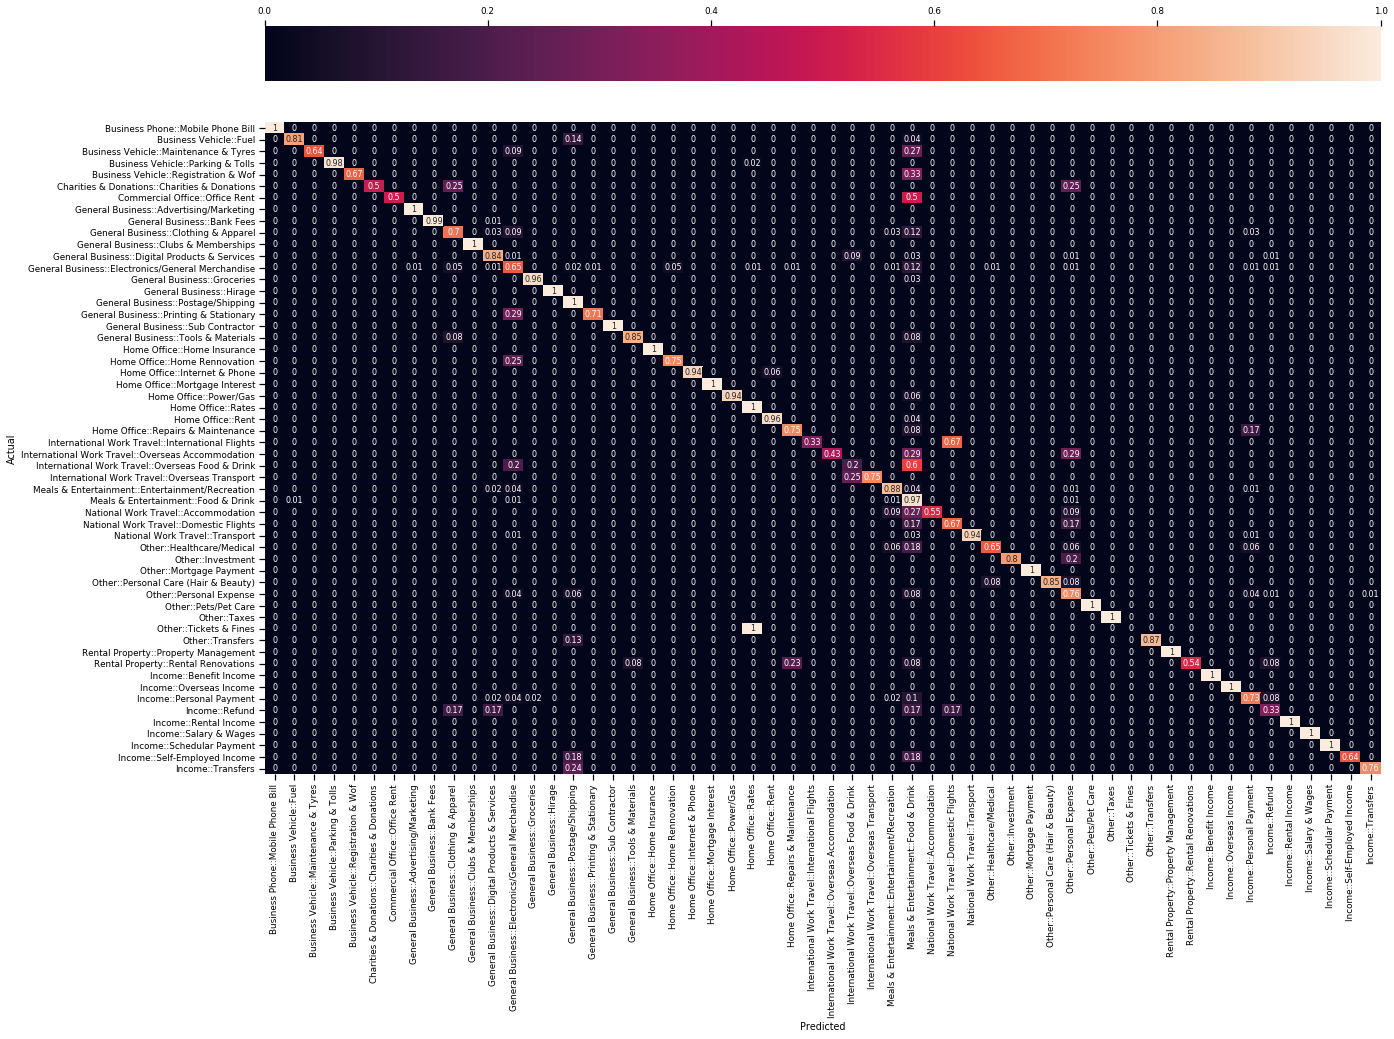

In [8]:
fasttext_result = ml_models.evaluate_pipeline(base_models['SVC'], X2, y)

## 2.3 GloVe

<div class='alert alert-warning'>
    <b>Load pre-trained model</b>
    <p>The GloVe 6B pre-trained model file size is larger than 300MB and 
     <br>The GloVe 42B pre-trained model file size is larger than 4.7 GB. 
      <br> Please make sure to have enough RAM for these files. </p>
    <p>The <code>glove.42B.300d.zip</code>, <code>glove.840B.300d.zip</code> file are available to download <a href ="https://github.com/stanfordnlp/GloVe">here</a> (From : https://github.com/stanfordnlp/GloVe)<br> Extract and pre-process with <code>'/utils/load_glove.py'</code> before this step.</p> 
    </div>

In [34]:
#Load pre-trained GloVe models
glove6b = pd.read_pickle(cf.GLOVE_6B_100D_P_FILE)
glove42b = pd.read_pickle(cf.GLOVE_42B_300D_P_FILE)

### - Analyse OOV words

In [35]:
def glove_oov_condition(glove, token):
    return token in glove
    
print('--- Glove6B ---')    
distinct_oov, total_oov, oob = text_embedding.analyse_oov(X, glove6b, glove_oov_condition)
print('--- Glove42B ---')    
distinct_oov, total_oov, oob = text_embedding.analyse_oov(X, glove42b, glove_oov_condition)

--- Glove6B ---
Distinct OOV words : 24.87%
Words represented by a vector of zeros : 9.70%
--- Glove42B ---
Distinct OOV words : 15.16%
Words represented by a vector of zeros : 5.98%


### - Benchmark

In [37]:
vectorizers['GloVe6B'] = text_embedding.MeanEmbeddingVectorizer(glove6b)
all_models['GloVe6B'] = make_pipeline(vectorizers['GloVe6B'], base_models['SVC'])

In [30]:
selected_keys = [ 'GloVe6B']
selected_models = {key: all_models[key] for key in selected_keys}
all_results = ml_models.benchmark_models(selected_models, X, y, train_sizes = None, export_results=True, n_jobs=-1)

In [38]:
vectorizers['GloVe42B'] = MeanEmbeddingVectorizer(glove42b)
all_models['GloVe42B'] = make_pipeline(vectorizers['GloVe42B'], base_models['SVC'])

In [6]:
selected_keys = [ 'GloVe42B']
selected_models = {key: all_models[key] for key in selected_keys}
all_results = ml_models.benchmark_models(selected_models, X, y, export_results=True, n_jobs=1)

GloVe42B : 100 ...200 ...400 ...800 ...1600 ...3200 ...6400 ...10000 ...done !
Export done! : /project/dissertation/output/embedding_benchmark_results/GloVe42B.csv


### - Classification Report & Confusion Matrix

Train : 10336  Test : 2584  Total : 12920
                                                             precision    recall  f1-score   support

                Expenses::Business Phone::Mobile Phone Bill       1.00      0.94      0.97        33
                           Expenses::Business Vehicle::Fuel       0.91      0.78      0.84        90
            Expenses::Business Vehicle::Maintenance & Tyres       1.00      0.55      0.71        11
                Expenses::Business Vehicle::Parking & Tolls       0.90      0.92      0.91        61
             Expenses::Business Vehicle::Registration & Wof       0.00      0.00      0.00         3
     Expenses::Charities & Donations::Charities & Donations       1.00      0.50      0.67         4
                   Expenses::Commercial Office::Office Rent       1.00      0.50      0.67         2
          Expenses::General Business::Advertising/Marketing       0.75      0.75      0.75         4
                      Expenses::General Business

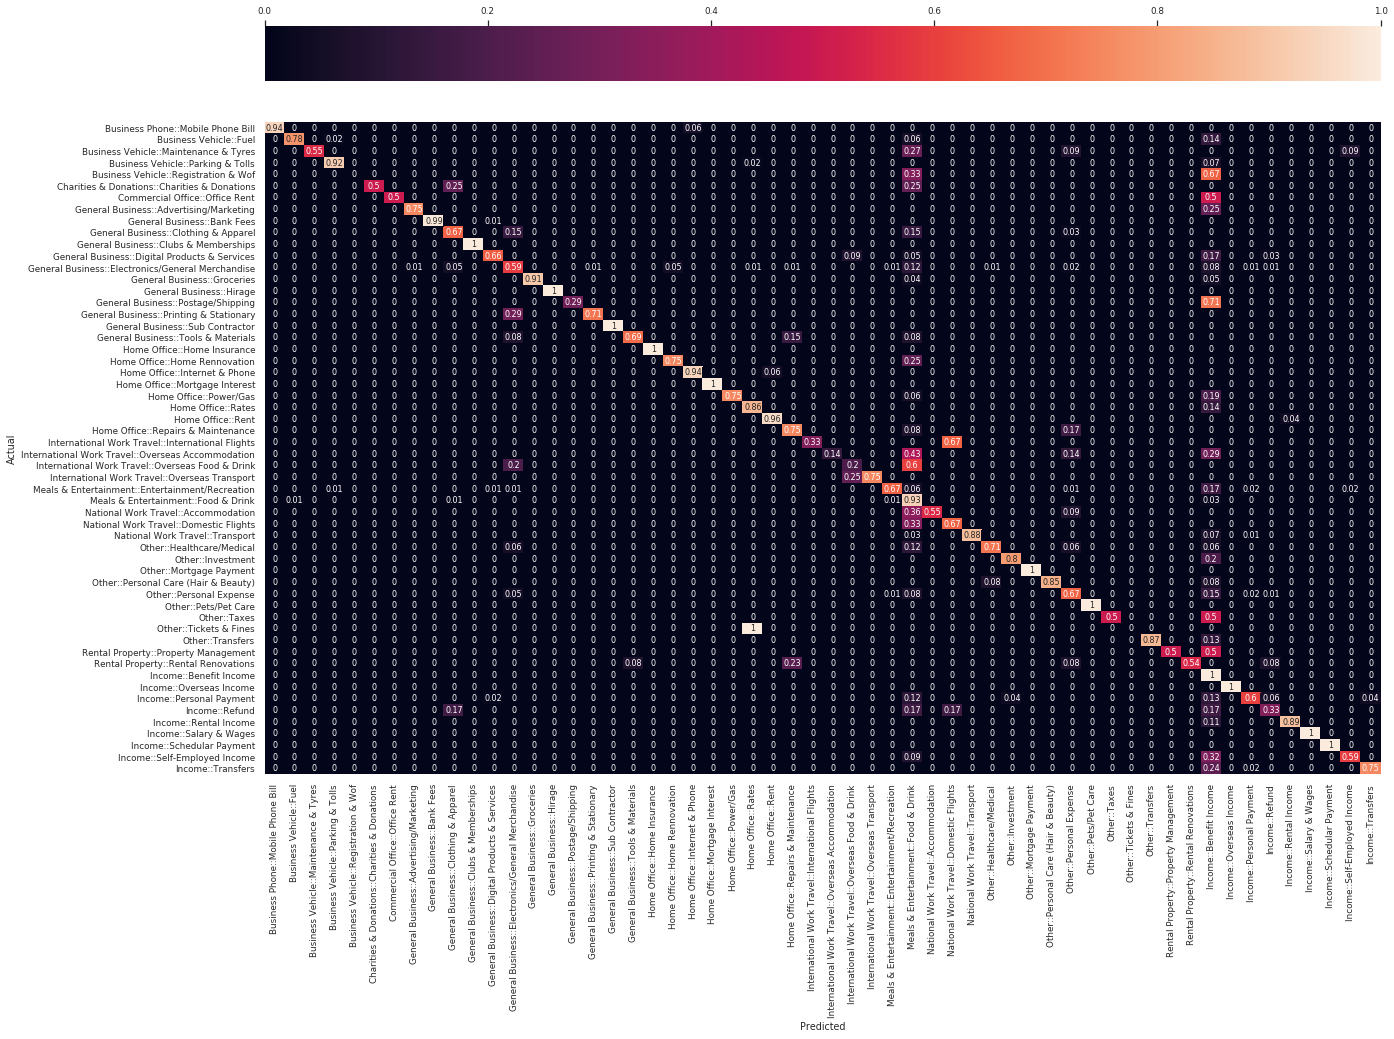

In [39]:
# sns.set_context('notebook', font_scale=0.8)
glove6b_result = ml_models.evaluate_pipeline(all_models['GloVe6B'], X, y)

Train : 10336  Test : 2584  Total : 12920
                                                             precision    recall  f1-score   support

                Expenses::Business Phone::Mobile Phone Bill       0.97      0.94      0.95        33
                           Expenses::Business Vehicle::Fuel       0.90      0.79      0.84        90
            Expenses::Business Vehicle::Maintenance & Tyres       1.00      0.64      0.78        11
                Expenses::Business Vehicle::Parking & Tolls       0.95      0.92      0.93        61
             Expenses::Business Vehicle::Registration & Wof       1.00      0.33      0.50         3
     Expenses::Charities & Donations::Charities & Donations       1.00      0.50      0.67         4
                   Expenses::Commercial Office::Office Rent       1.00      0.50      0.67         2
          Expenses::General Business::Advertising/Marketing       0.80      1.00      0.89         4
                      Expenses::General Business

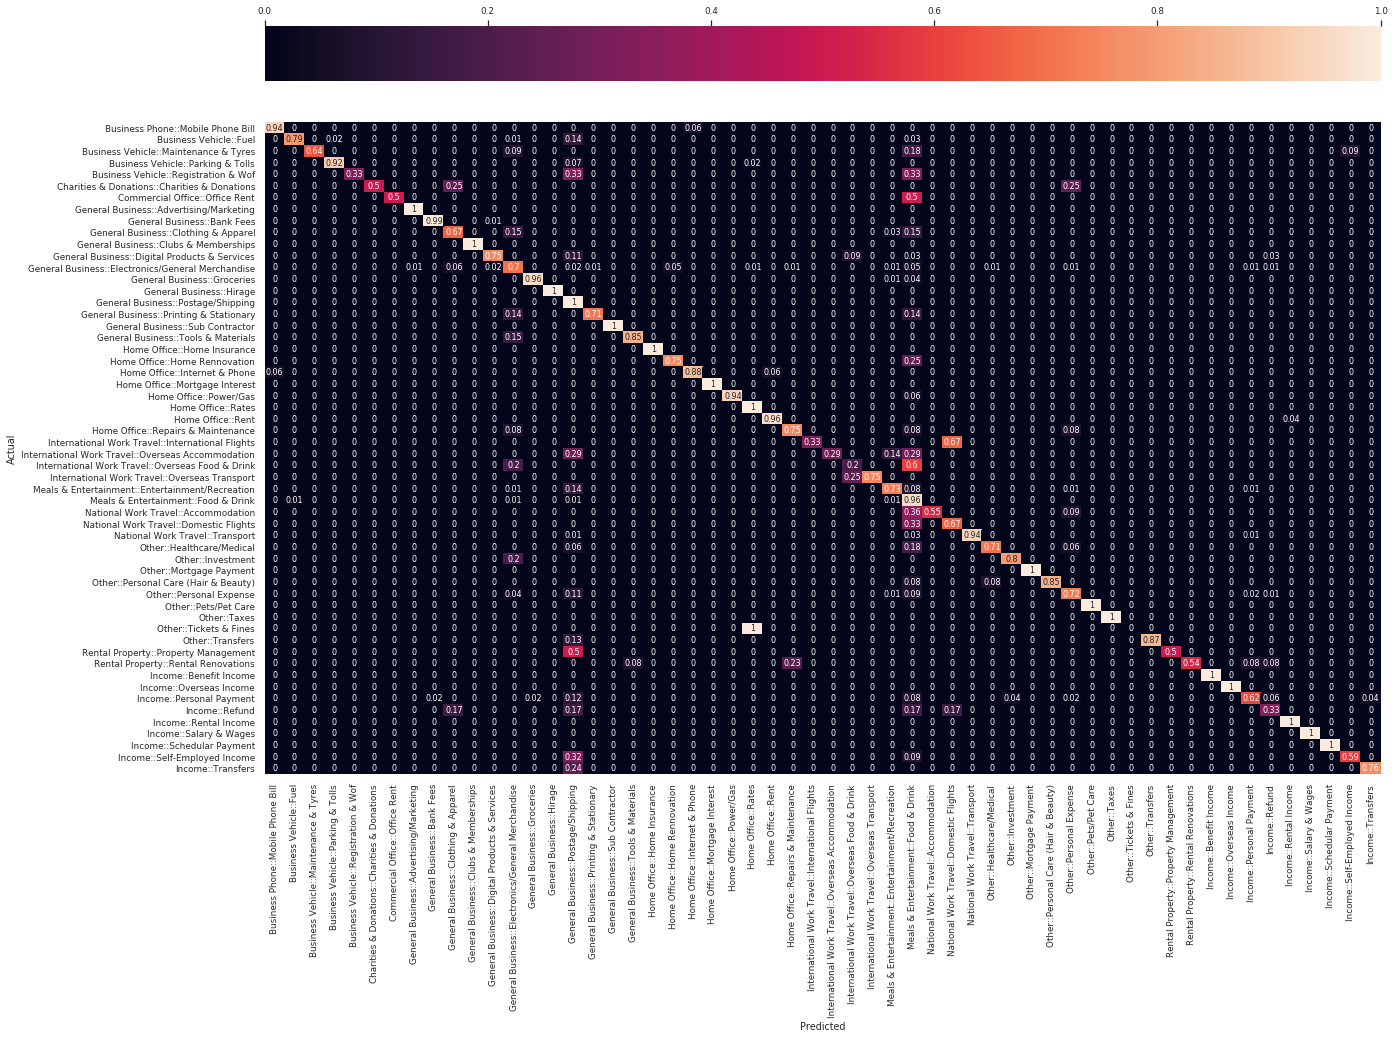

In [40]:
glove42b_result = ml_models.evaluate_pipeline(all_models['GloVe42B'], X, y)

----------------------------------------
## 3. Bag-of-Words, TF-iDF, GloVe model results

### - CV Score of Bag-of-Words, TF-iDF, GloVe model 

In [21]:
unsorted_scores = list()
for vectorizer_name, vectorizer in vectorizers.items():
    model_name = 'SVC'
    model = base_models[model_name]
    key = vectorizer_name
    pipeline = make_pipeline(vectorizer, model)
    scoring = {'accuracy': 'accuracy',  'precision': 'precision_macro', 'recall': 'recall_macro', 'f1': 'f1_macro'}
    score = cross_validate(pipeline, X, y, cv=kfold, scoring=scoring, return_train_score=False)
    ml_models.export_results(vectorizer_name, score)
    unsorted_scores.append({'Vectorizer': vectorizer_name, 'Accuracy': score['test_accuracy'].mean(), 'Precision':score['test_precision'].mean(), 
                           'Recall': score['test_recall'].mean(), 'F1-score': score['test_f1'].mean()})

Export done! :  /project/dissertation/output/embedding_results/Bag-Of-Words.csv
Export done! :  /project/dissertation/output/embedding_results/TF-iDF.csv


### - Benchmark Bag-of-Words, TF-iDF

In [22]:
from importlib import reload 
reload(ml_models)

selected_keys = all_models.keys()
selected_models = {key: all_models[key] for key in selected_keys}
# train_sizes = [12000]
all_results = ml_models.benchmark_models(selected_models, X, y, train_sizes=None, export_results=True, n_jobs=1)
all_results.head()

Bag-Of-Words : 100 ...200 ...400 ...800 ...1600 ...3200 ...6400 ...10000 ...done !
Export done! : /project/dissertation/output/embedding_benchmark_results/Bag-Of-Words.csv
TF-iDF : 100 ...200 ...400 ...800 ...1600 ...3200 ...6400 ...10000 ...done !
Export done! : /project/dissertation/output/embedding_benchmark_results/TF-iDF.csv


,model,score,score_type,train_size
0,Bag-Of-Words,0.988440,train,100
1,Bag-Of-Words,0.189606,test,100
2,Bag-Of-Words,0.975800,train,200
3,Bag-Of-Words,0.300466,test,200
4,Bag-Of-Words,0.973965,train,400


### - Classification Report & Confusion Matrix

Train : 10336  Test : 2584  Total : 12920
                                                             precision    recall  f1-score   support

                Expenses::Business Phone::Mobile Phone Bill       1.00      1.00      1.00        33
                           Expenses::Business Vehicle::Fuel       0.88      0.78      0.82        90
            Expenses::Business Vehicle::Maintenance & Tyres       1.00      0.55      0.71        11
                Expenses::Business Vehicle::Parking & Tolls       1.00      0.98      0.99        61
             Expenses::Business Vehicle::Registration & Wof       1.00      0.67      0.80         3
     Expenses::Charities & Donations::Charities & Donations       1.00      0.50      0.67         4
                   Expenses::Commercial Office::Office Rent       1.00      0.50      0.67         2
          Expenses::General Business::Advertising/Marketing       0.80      1.00      0.89         4
                      Expenses::General Business

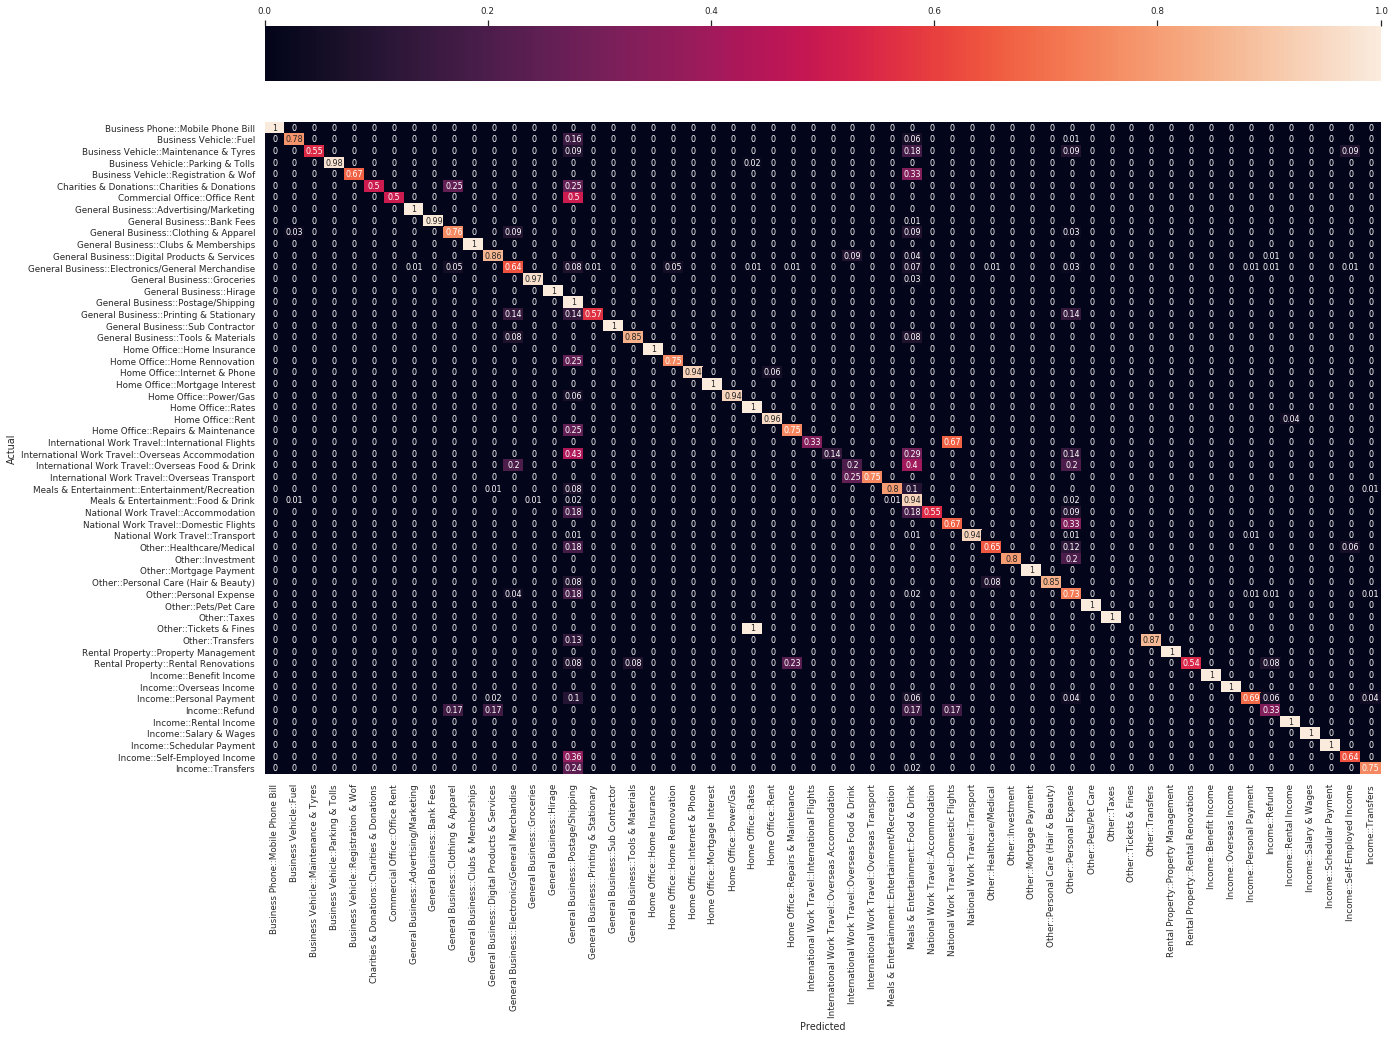

In [27]:
bow_result = ml_models.evaluate_pipeline(all_models['Bag-Of-Words'], X, y)

Train : 10336  Test : 2584  Total : 12920
                                                             precision    recall  f1-score   support

                Expenses::Business Phone::Mobile Phone Bill       1.00      1.00      1.00        33
                           Expenses::Business Vehicle::Fuel       0.86      0.79      0.82        90
            Expenses::Business Vehicle::Maintenance & Tyres       0.88      0.64      0.74        11
                Expenses::Business Vehicle::Parking & Tolls       1.00      0.98      0.99        61
             Expenses::Business Vehicle::Registration & Wof       1.00      0.67      0.80         3
     Expenses::Charities & Donations::Charities & Donations       1.00      0.50      0.67         4
                   Expenses::Commercial Office::Office Rent       1.00      0.50      0.67         2
          Expenses::General Business::Advertising/Marketing       0.80      1.00      0.89         4
                      Expenses::General Business

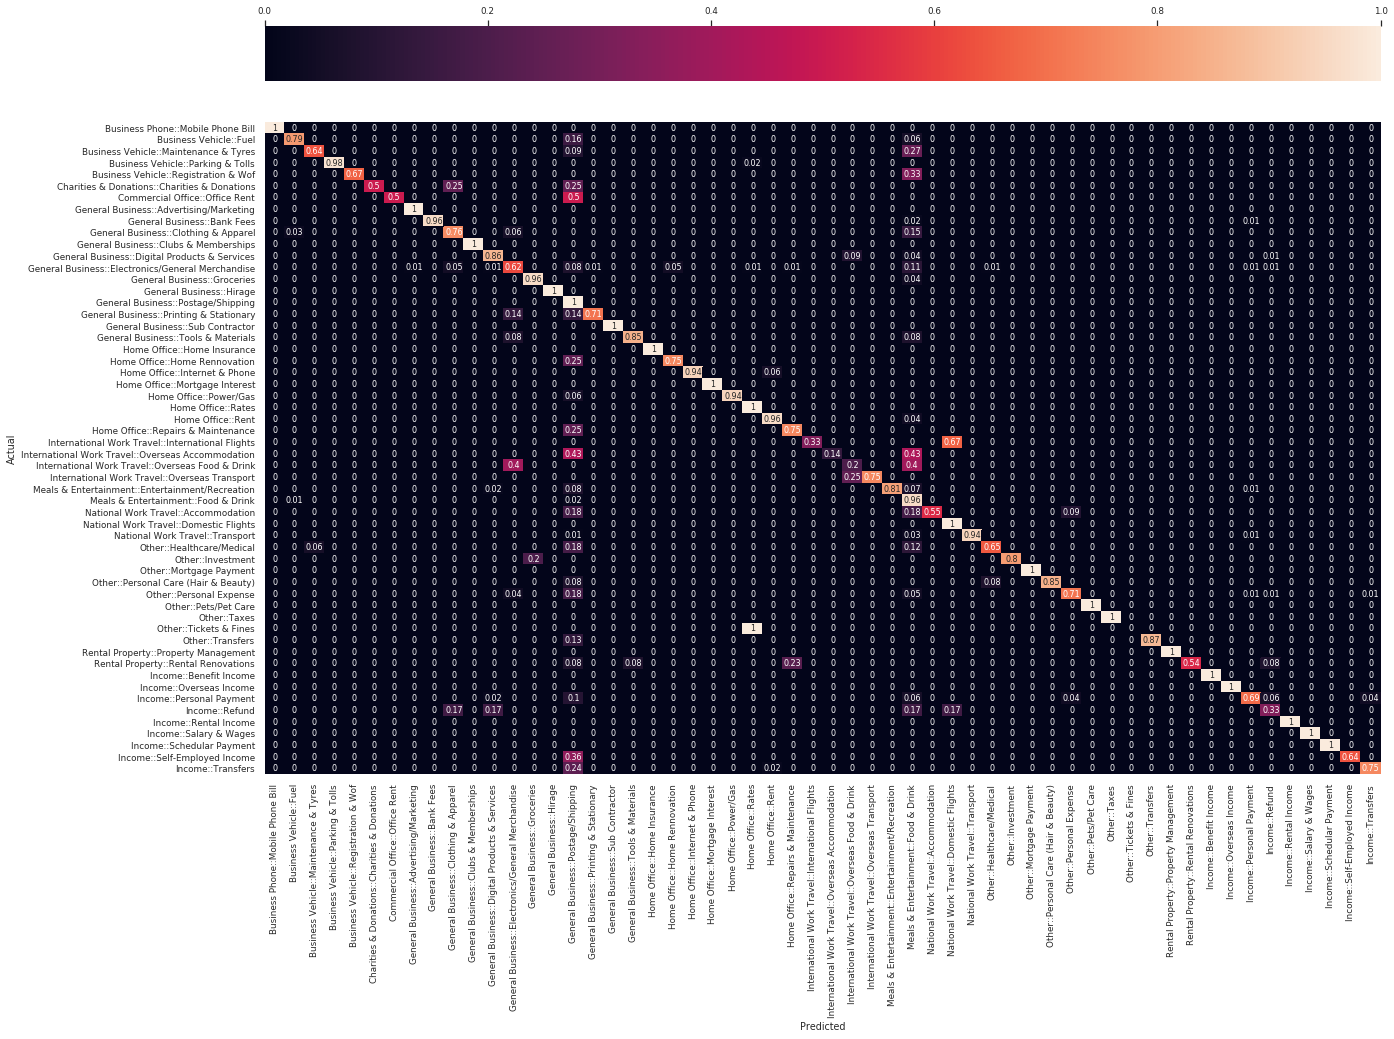

In [28]:
tfidf_result = ml_models.evaluate_pipeline(all_models['TF-iDF'], X, y)

------------------------------------------------------------------------------------
## 4. Load all results from file and generate chart

## 4.1 CV Score

In [29]:
import glob
path = cf.EXPORT_PATH + 'embedding_results/*.csv'

data = list()
for filename in glob.glob(path):
    print(filename)
    data.append(pd.read_csv(filename))
all_results = pd.concat(data, ignore_index=True, sort=False)
all_results['index'] = [2,1,5,6,4,3]
all_results = all_results.sort_values('index')

/project/dissertation/output/embedding_results/TF-iDF.csv
/project/dissertation/output/embedding_results/Bag-Of-Words.csv
/project/dissertation/output/embedding_results/W2V.csv
/project/dissertation/output/embedding_results/FastText.csv
/project/dissertation/output/embedding_results/GloVe42B.csv
/project/dissertation/output/embedding_results/GloVe6B.csv


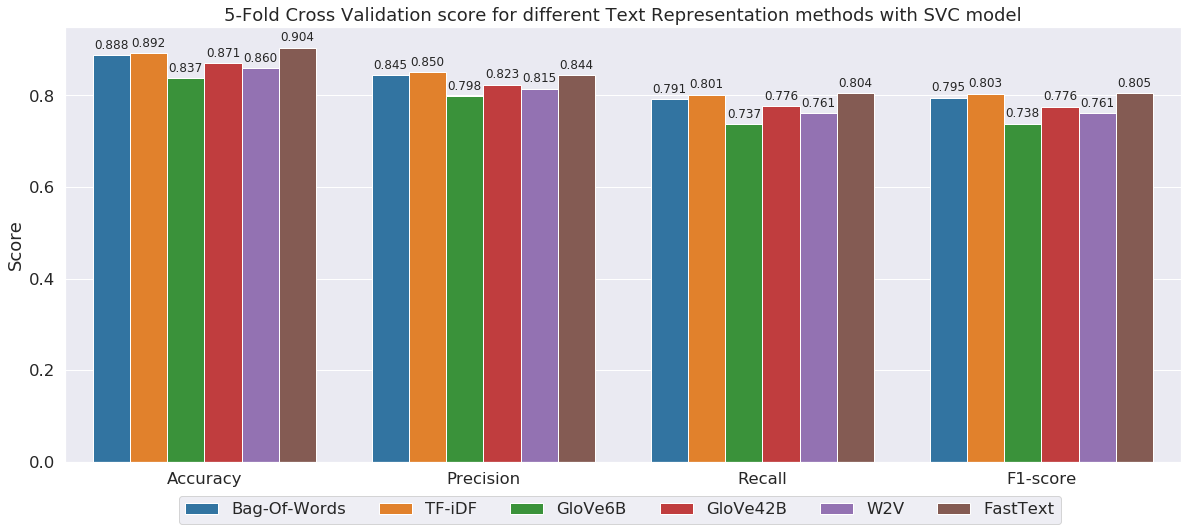

In [30]:
all_scores = all_results.melt(id_vars='Model', value_vars=['Accuracy', 'Precision','Recall','F1-score'], var_name='Score_type', value_name='Score')
plt.figure(figsize=(20, 8))
sns.set_style('darkgrid')
sns.set_context('notebook', font_scale=1.5)
fig = sns.barplot(y='Score', x='Score_type', data=all_scores, hue='Model', palette='tab10')
fig.set(title="5-Fold Cross Validation score for different Text Representation methods with SVC model")
#Annotate bar
for p in fig.patches:
    fig.annotate(format(p.get_height(), '.3f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', fontsize=12)
fig.set(xlabel="")
fig.legend(loc='center right', bbox_to_anchor=(0.9, -0.11), ncol=6)

## 4.2 Benchmark Score

In [31]:
import glob
path = cf.EXPORT_PATH + 'embedding_benchmark_results/*.csv'
index_map = {'Bag-Of-Words':1 , 'TF-iDF':2, 'GloVe6B':3, 'GloVe42B':4, 'W2V':5, 'FastText':6}

data = list()
for filename in glob.glob(path):
    print(filename)
    data.append(pd.read_csv(filename))
all_results = pd.concat(data, ignore_index=True, sort=False)
all_results['index'] = all_results['model'].map(index_map)
all_results = all_results.sort_values('index')

/project/dissertation/output/embedding_benchmark_results/TF-iDF.csv
/project/dissertation/output/embedding_benchmark_results/Bag-Of-Words.csv
/project/dissertation/output/embedding_benchmark_results/W2V.csv
/project/dissertation/output/embedding_benchmark_results/FastText.csv
/project/dissertation/output/embedding_benchmark_results/GloVe42B.csv
/project/dissertation/output/embedding_benchmark_results/GloVe6B.csv


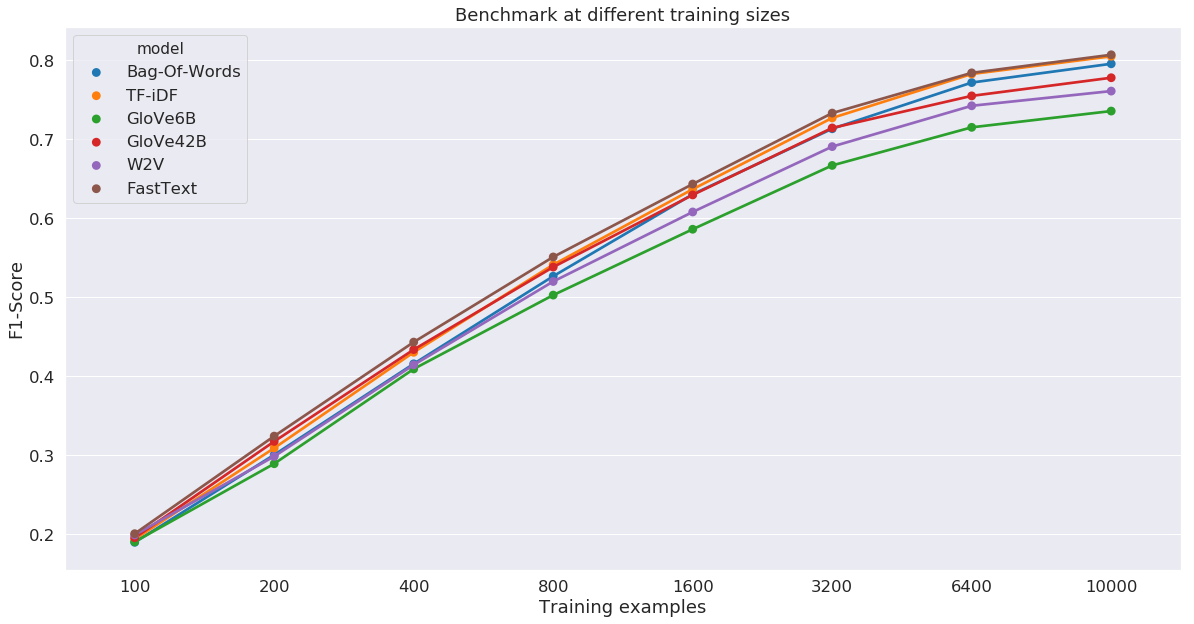

In [32]:
sns.set()
sns.set_palette('tab10')
sns.set_context('notebook', font_scale=1.5)
ml_models.plot_benchmark_test_score(figsize = (20,10), df=all_results, model_list = None)
# plt.savefig(cf.EXPORT_PATH + 'benchmark_final.png', bbox_inches='tight')

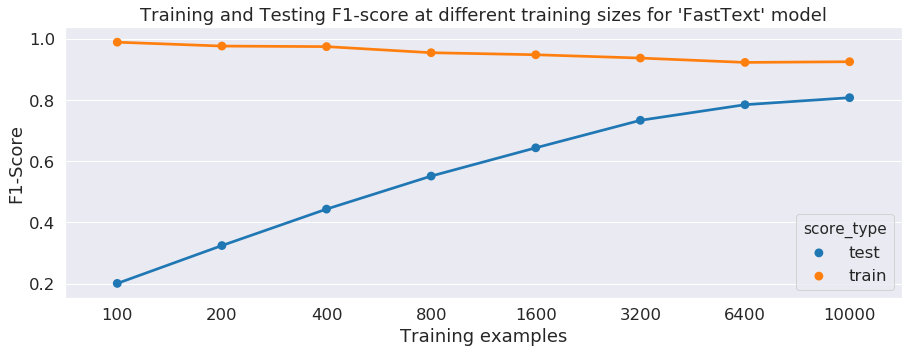

In [33]:
ml_models.plot_benchmark_train_test_score(all_results, 'FastText')
# plt.savefig(cf.EXPORT_PATH + 'benchmark_svc_linear.png', bbox_inches='tight')

----------------------------------------------------------------------
## Save Text Embeddings for later used

In [18]:
for model in vectorizers:
    transformed = vectorizers[model].fit_transform(X, y)
    np.save(cf.EXPORT_PATH + 'text_embeddings/'+model, transformed)
    print('Vectorizer : {} exported!'.format(model))

Vectorizer : Bag-Of-Words exported!
Vectorizer : TF-iDF exported!
Vectorizer : FastText exported!
